<a href="https://colab.research.google.com/github/GAOYUEtianc/DNA_discriminator/blob/main/DNA_Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
# Read the DNA sequences from csv
import pandas as pd 
Trainsequence = pd.read_csv('/content/gdrive/My Drive/train.csv')
print(Trainsequence.shape)

(7499, 1)


In [30]:
import numpy as np
import random
import string
# Convert each DNA sequence into a one-hot matrix
n = Trainsequence.shape[0]
X_train = np.zeros((n, 100, 4)) # For each sequence (of length at most 100, there're 4 possible bases)
mapping = dict(zip("ACGT", range(4)))
for i in range(0,n):
    seq = [mapping[j] for j in Trainsequence.iloc[i][0]]
    X_train[i,:len(Trainsequence.iloc[i][0]),:] = np.eye(4)[seq]
y_train = np.ones((n, 1))
# Get Reverse DNA sequence 
X_train_inverse = np.zeros((n, 100, 4))
correspond = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
for i in range(0,n):
    reverse_string = "".join(correspond[base] for base in reversed(Trainsequence.iloc[i][0]))
    seq = [mapping[j] for j in reverse_string]
    X_train_inverse[i,:len(Trainsequence.iloc[i][0]),:] = np.eye(4)[seq]
y_train_inverse = np.zeros((n, 1))

# Get negative sequence by shuffling the positive ones
X_nega = np.zeros(X_train.shape)
for i in range(0,n):
    seq_i = Trainsequence.iloc[i][0]
    shuffle_seq = ''.join(random.sample(seq_i, len(seq_i)))
    seq = [mapping[j] for j in shuffle_seq]
    X_nega[i,:len(shuffle_seq),:] = np.eye(4)[seq]
y_train_nega = np.zeros((n, 1))

In [31]:
from keras.models import Model
from keras import Input
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose, Embedding, LSTM, Dense, BatchNormalization, Concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D


In [32]:
input_layer = Input(shape=(100,4,1))

# Convolutional Layer extracting features from data
kernel_size = (5,5)
strides_size = (3,3)
# First Layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(input_layer)
x = LeakyReLU(alpha = 0.2)(x)
# Second layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(x)
x_conv = LeakyReLU(alpha = 0.2)(x)
# Max pooling , then flatten
x_output_1 = MaxPooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_1 = Flatten()(x_output_1)
# Average pooling , then flatten
x_output_2 = AveragePooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_2 = Flatten()(x_output_2)

# Concatenate the output of MaxPooling and Average Pooling 
output = Concatenate(axis = 1)((x_output_1, x_output_2))

# Do batch normalization
output = BatchNormalization(epsilon=1e-06, momentum=0.95)(output, training=True)
# Add a fully connected layer 
output = Dense(50, activation='relu')(output)
# Dropout features to prevent overfitting
output = Dropout(0.5)(output)
# Add another fully connected layer
output = Dense(1, activation='sigmoid')(output)
Discriminator_Model = Model(input_layer, output)
Discriminator_Model.compile(loss = 'binary_crossentropy', metrics='accuracy')

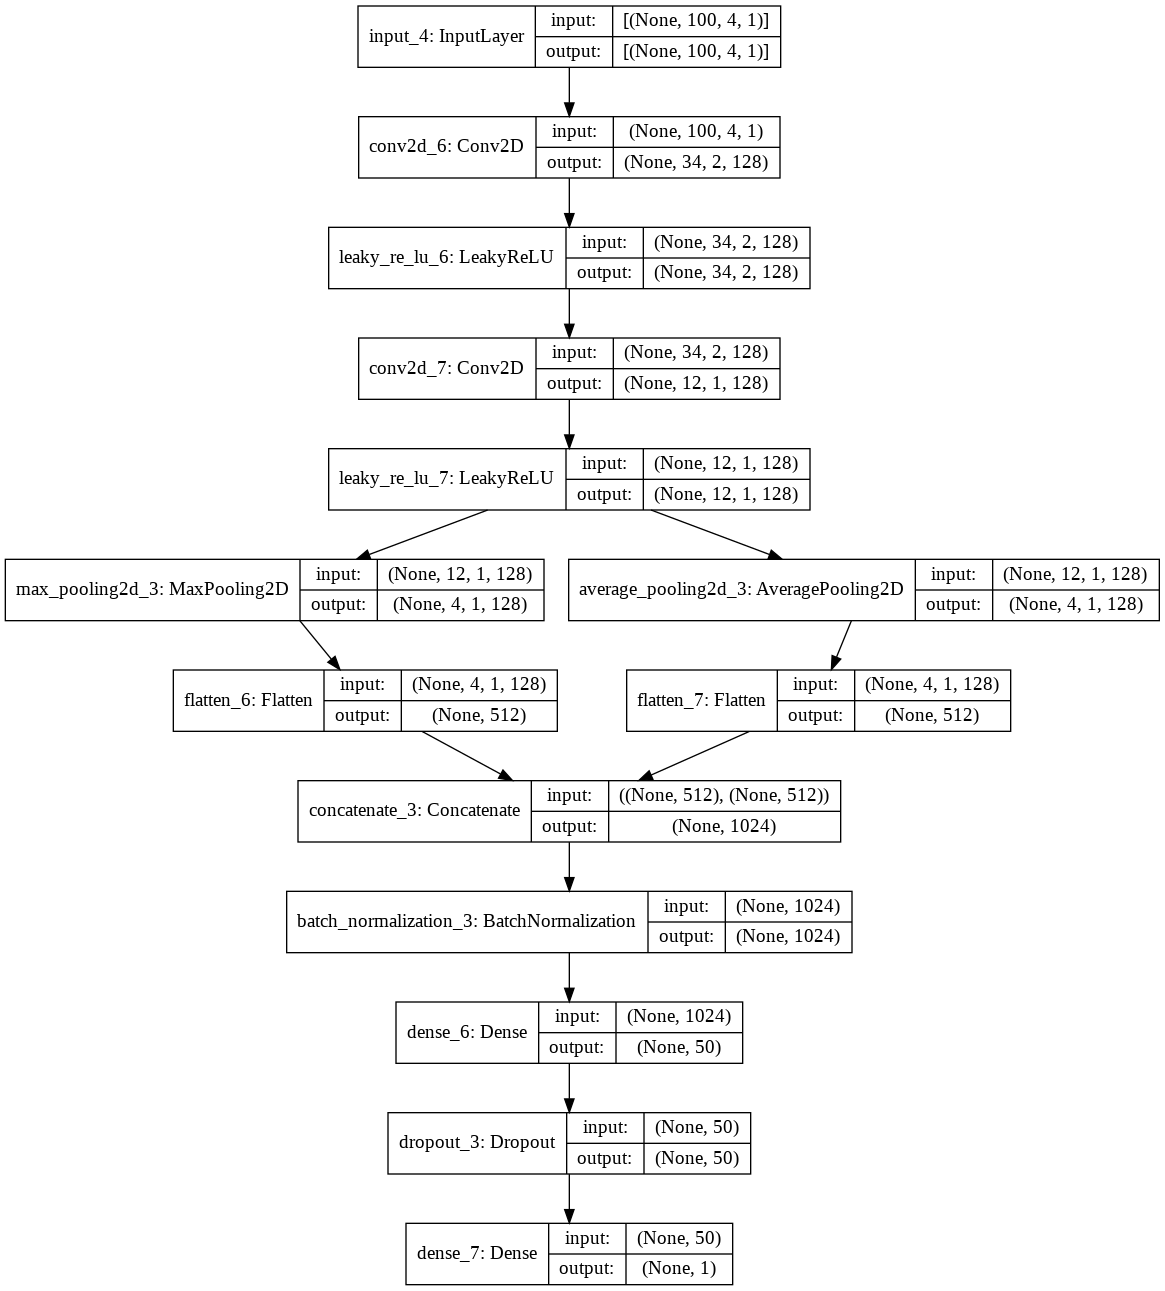

In [33]:
# Plot the model
from keras.utils.vis_utils import plot_model
plot_model(Discriminator_Model,show_shapes=True)

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
path = F"/content/gdrive/My Drive/DNA_Discriminator.hdf5"
checkpointer = ModelCheckpoint(filepath=path, verbose=1, save_best_only=False)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


In [35]:
# Combine the Training dataset (Using Inverse Seq as the negative data) and shuffle it
X = np.vstack((X_train, X_train_inverse))
y = np.vstack((y_train, y_train_inverse))
print(X.shape)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

(14998, 100, 4)


In [36]:
n_train = int(0.8*n)
X_Train = X[:n_train]
y_Train = y[:n_train]
X_Test_1 = X[n_train:]
y_Test_1 = y[n_train:]
Discriminator_Model.fit(X_Train, y_Train, batch_size=100, epochs=30, shuffle=True, verbose=1, validation_data=(X_Test_1, y_Test_1), callbacks=[checkpointer,earlystopper])
Discriminator_Model.save(path)

Epoch 1/30
60/60 [==============================] - 13s 202ms/step - loss: 0.4245 - accuracy: 0.8085 - val_loss: 0.1676 - val_accuracy: 0.9354

Epoch 00001: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 2/30
60/60 [==============================] - 12s 198ms/step - loss: 0.1458 - accuracy: 0.9460 - val_loss: 0.1063 - val_accuracy: 0.9584

Epoch 00002: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 3/30
60/60 [==============================] - 12s 200ms/step - loss: 0.0760 - accuracy: 0.9705 - val_loss: 0.0864 - val_accuracy: 0.9697

Epoch 00003: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 4/30
60/60 [==============================] - 12s 198ms/step - loss: 0.0458 - accuracy: 0.9843 - val_loss: 0.0820 - val_accuracy: 0.9713

Epoch 00004: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 5/30
60/60 [==============================] - 12s 203ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0

In [37]:
# Combine the Training dataset (Using Random Suffled Seq as the negative data) and shuffle it
X = np.vstack((X_train, X_nega))
y = np.vstack((y_train, y_train_nega))
print(X.shape)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

(14998, 100, 4)


In [38]:
# Train the 2nd model using the shuffled data
input_layer = Input(shape=(100,4,1))

# Convolutional Layer extracting features from data
kernel_size = (5,5)
strides_size = (3,3)
# First Layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(input_layer)
x = LeakyReLU(alpha = 0.2)(x)
# Second layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(x)
x_conv = LeakyReLU(alpha = 0.2)(x)
# Max pooling , then flatten
x_output_1 = MaxPooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_1 = Flatten()(x_output_1)
# Average pooling , then flatten
x_output_2 = AveragePooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_2 = Flatten()(x_output_2)

# Concatenate the output of MaxPooling and Average Pooling 
output = Concatenate(axis = 1)((x_output_1, x_output_2))

# Do batch normalization
output = BatchNormalization(epsilon=1e-06, momentum=0.95)(output, training=True)
# Add a fully connected layer 
output = Dense(50, activation='relu')(output)
# Dropout features to prevent overfitting
output = Dropout(0.5)(output)
# Add another fully connected layer
output = Dense(1, activation='sigmoid')(output)
Discriminator_Model_2 = Model(input_layer, output)
Discriminator_Model_2.compile(loss = 'binary_crossentropy', metrics='accuracy')

from keras.callbacks import ModelCheckpoint, EarlyStopping
path = F"/content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5"
checkpointer = ModelCheckpoint(filepath=path, verbose=1, save_best_only=False)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
n_train = int(0.8*n)
X_Train = X[:n_train]
y_Train = y[:n_train]
X_Test_2 = X[n_train:]
y_Test_2 = y[n_train:]
Discriminator_Model_2.fit(X_Train, y_Train, batch_size=100, epochs=30, shuffle=True, verbose=1, validation_data=(X_Test_2, y_Test_2), callbacks=[checkpointer,earlystopper])
Discriminator_Model_2.save(path)


Epoch 1/30
60/60 [==============================] - 13s 201ms/step - loss: 0.4863 - accuracy: 0.7735 - val_loss: 0.2307 - val_accuracy: 0.9090

Epoch 00001: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 2/30
60/60 [==============================] - 12s 200ms/step - loss: 0.1935 - accuracy: 0.9280 - val_loss: 0.1527 - val_accuracy: 0.9423

Epoch 00002: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 3/30
60/60 [==============================] - 12s 199ms/step - loss: 0.1316 - accuracy: 0.9543 - val_loss: 0.1340 - val_accuracy: 0.9523

Epoch 00003: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 4/30
60/60 [==============================] - 12s 198ms/step - loss: 0.0935 - accuracy: 0.9655 - val_loss: 0.1270 - val_accuracy: 0.9567

Epoch 00004: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 5/30
60/60 [==============================] - 12s 199ms/step - loss: 0.0740 - 

(8999, 1)
AUC for discriminator_1 (use reverse seq as training data) : 0.9978700560049094
AUPRC for discriminator_1 (use reverse seq as training data) : 0.9978006976578714


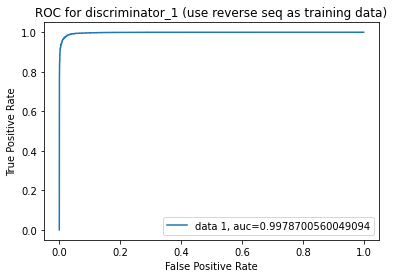

In [39]:
# Evaluate the Model 1
from sklearn.metrics import roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
pred = Discriminator_Model.predict(X_Test_1)
print(pred.shape)
fpr, tpr, thresholds = roc_curve(y_Test_1, pred)
AUC = auc(fpr, tpr)
AUPRC = average_precision_score(y_Test_1, pred)
print("AUC for discriminator_1 (use reverse seq as training data) :", AUC)
print("AUPRC for discriminator_1 (use reverse seq as training data) :", AUPRC)
plt.plot(fpr,tpr,label="data 1, auc="+str(AUC))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for discriminator_1 (use reverse seq as training data)")
plt.legend(loc=4)
plt.show()

(8999, 1)
AUC for discriminator_2 (use shuffled seq as training data) : 0.9916465120690472
AUPRC for discriminator_2 (use shuffled seq as training data) : 0.9905255882438705


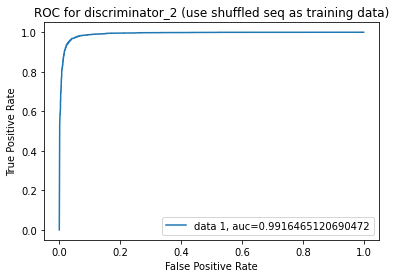

In [40]:
# Evaluate the Model 2
from sklearn.metrics import roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
pred = Discriminator_Model_2.predict(X_Test_2)
print(pred.shape)
fpr, tpr, thresholds = roc_curve(y_Test_2, pred)
AUC = auc(fpr, tpr)
AUPRC = average_precision_score(y_Test_2, pred)
print("AUC for discriminator_2 (use shuffled seq as training data) :", AUC)
print("AUPRC for discriminator_2 (use shuffled seq as training data) :", AUPRC)
plt.plot(fpr,tpr,label="data 1, auc="+str(AUC))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for discriminator_2 (use shuffled seq as training data)")
plt.legend(loc=4)
plt.show()